# Enron data EDA and preprocessing

## 1 Import libraries

Import the required libraries for data manipulation, email and HTML parsing, text cleaning, and data visualisations.

In [ ]:
print("Loading libraries...")

# Core libraries
import os
import pandas as pd
import numpy as np
import re
import logging
import time

# Kaggle API
import kagglehub

# Email parsing
import email
from email import policy
from email.parser import BytesParser, Parser
from email.utils import parsedate_to_datetime, getaddresses

# HTML processing
from bs4 import BeautifulSoup

# Text processing
import unicodedata

# EDA visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas display options
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 200)

print("Libraries imported.")

Loading libraries...
Libraries imported.


## 2 Load raw Enron data

Load the Enron email dataset via the Kaggle API. The Kaggle dataset (`wcukierski/enron-email-dataset`) provides a CSV (`emails.csv`) that maps file paths to the raw email messages. We will primarily use this to access and parse the email content.

In [ ]:
ENRON_CSV_PATH = None

# Initialize as empty
df_enron_meta = pd.DataFrame()

try:
    print("Downloading/accessing Enron email dataset metadata via kagglehub...")
    enron_dataset_path = kagglehub.dataset_download("wcukierski/enron-email-dataset")
    print(f"Kagglehub reported dataset path: {enron_dataset_path}")

    # List contents of the reported path for verification
    print(f"\n--- Contents of '{enron_dataset_path}': ---")
    if os.path.exists(enron_dataset_path) and os.path.isdir(enron_dataset_path):
        for item in os.listdir(enron_dataset_path):
            print(item)
    else:
        print(f"ERROR: The path '{enron_dataset_path}' reported by kagglehub does not exist or is not a directory.")
    print("--- End of directory contents ---\n")

    ENRON_CSV_PATH = os.path.join(enron_dataset_path, 'emails.csv')
    print(f"Constructed path to emails.csv: {ENRON_CSV_PATH}")

    emails_csv_exists = os.path.exists(ENRON_CSV_PATH)

    if emails_csv_exists:
        df_enron_meta = pd.read_csv(ENRON_CSV_PATH)
        print(f"\nSuccessfully loaded {ENRON_CSV_PATH}. Shape: {df_enron_meta.shape}")
        print("Metadata (emails.csv) head:")

        # Displaying head AND ensuring 'message' column is shown if it exists
        print(df_enron_meta.head())
        if 'message' not in df_enron_meta.columns:
            print("\nERROR: The crucial 'message' column (containing raw email text) is not in emails.csv!")
            print("Please verify the structure of your emails.csv file.")
            df_enron_meta = pd.DataFrame()
        else:
            print("\n'message' column found in emails.csv.")
    else:
        print(f"ERROR: 'emails.csv' NOT found at the constructed path: {ENRON_CSV_PATH}")
        print("Please check the printed directory contents from kagglehub and adjust paths if necessary.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Ensure kagglehub is installed and you have appropriate Kaggle API credentials configured if needed.")

Downloading/accessing Enron email dataset metadata via kagglehub...
Kagglehub reported dataset path: /kaggle/input/enron-email-dataset

--- Contents of '/kaggle/input/enron-email-dataset': ---
emails.csv
--- End of directory contents ---

Constructed path to emails.csv: /kaggle/input/enron-email-dataset/emails.csv

Successfully loaded /kaggle/input/enron-email-dataset/emails.csv. Shape: (517401, 2)
Metadata (emails.csv) head:
                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                                                                                                                                                                                   message  
0  Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMim

## 3 Initial Data Exploration (EDA)

Basic exploration on the loaded set, viewing some of the sample messages.

- Understand the structure of `emails.csv`.
- Look at how many emails and any initial missing values in the metadata.
- Examine a few rae email objects (`message_obj`) to see their structure, i.e. headers, payload, multipart.

In [ ]:
if not df_enron_meta.empty:
    print("--- Metadata Info ---")

    # show_counts=True for non-null counts
    df_enron_meta.info(show_counts=True)

    print(f"\n--- Missing values in metadata ---")
    print(df_enron_meta.isnull().sum())

    # Check for missing values in the 'message' column specifically
    if 'message' in df_enron_meta.columns:
        print(f"\nMissing values in 'message' column: {df_enron_meta['message'].isnull().sum()}")

        # Drop rows where the 'message' content is missing, as we can't parse them
        df_enron_meta.dropna(subset=['message'], inplace=True)
        print(f"Shape after dropping rows with missing 'message': {df_enron_meta.shape}")

    print(f"\n--- Unique values in 'file' (first 5 to see user structure) ---")
    df_enron_meta['user'] = df_enron_meta['file'].apply(lambda x: x.split('/')[0])
    print(f"Number of unique users found in file paths: {df_enron_meta['user'].nunique()}")
    print("Top 5 users by email count:")
    print(df_enron_meta['user'].value_counts().nlargest(5))

    if 'message' in df_enron_meta.columns:
        print("\n--- Example raw message content (first 500 chars of first message) ---")
        print(df_enron_meta['message'].iloc[0][:500])
else:
    print("df_enron_meta is empty. Skipping EDA on metadata.")

--- Metadata Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB

--- Missing values in metadata ---
file       0
message    0
dtype: int64

Missing values in 'message' column: 0
Shape after dropping rows with missing 'message': (517401, 2)

--- Unique values in 'file' (first 5 to see user structure) ---
Number of unique users found in file paths: 150
Top 5 users by email count:
user
kaminski-v    28465
dasovich-j    28234
kean-s        25351
mann-k        23381
jones-t       19950
Name: count, dtype: int64

--- Example raw message content (first 500 chars of first message) ---
Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com

## 4 Define preprocessing functions

Define the relevant functions to extract the require information, such as sender, subject timestamps, and email body. This includes:

- Text content from email objects, including multipart emails.
- Stripping HTML and retaining hyperlink destinations.
- Perform basic text cleaning such as lowercase, extra whitespace, and special characters.
- Apply NFKC normalisation.

In [ ]:
def get_email_body_and_urls(message_obj):
    """
    Extracts text body and URLs from an email.Message object.
    Tries plain text first, then HTML. Extracts hrefs from <a> tags in HTML.
    """

    body_text = ""
    html_body_text = ""
    urls_in_html = []

    if message_obj is None: return "", []

    if message_obj.is_multipart():
        for part in message_obj.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get_content_disposition())

            if "attachment" not in content_disposition:

                # Prioritize first plain text part
                if content_type == "text/plain" and not body_text:

                    try:
                        payload = part.get_payload(decode=True)
                        charset = part.get_content_charset() or 'utf-8'
                        body_text = payload.decode(charset, errors='replace')

                    except Exception: pass

                # Store first HTML part
                elif content_type == "text/html" and not html_body_text:

                    try:
                        payload = part.get_payload(decode=True)
                        charset = part.get_content_charset() or 'utf-8'
                        html_content = payload.decode(charset, errors='replace')
                        html_body_text = html_content
                        soup_part = BeautifulSoup(html_content, 'html.parser')

                        for link_tag in soup_part.find_all('a', href=True):
                            urls_in_html.append(link_tag['href'])

                    except Exception: pass

    # Not multipart
    else:
        content_type = message_obj.get_content_type()
        try:
            payload = message_obj.get_payload(decode=True)
            charset = message_obj.get_content_charset() or 'utf-8'

            if content_type == "text/plain":
                body_text = payload.decode(charset, errors='replace')

            elif content_type == "text/html":
                html_body_text = payload.decode(charset, errors='replace')
                soup_part = BeautifulSoup(html_body_text, 'html.parser')

                for link_tag in soup_part.find_all('a', href=True):
                    urls_in_html.append(link_tag['href'])

        except Exception: pass

    # Logic to decide final body: prefer plain. If not, clean HTML.
    final_body = ""
    if body_text.strip():
        final_body = body_text

    elif html_body_text.strip():
        soup = BeautifulSoup(html_body_text, 'html.parser')

        # Extract text, trying to preserve some structure with spaces
        # Remove script and style elements
        for script_or_style in soup(["script", "style"]):
            script_or_style.decompose()
        final_body = soup.get_text(separator=' ', strip=True)

    return final_body, list(set(urls_in_html)) # Unique URLs

In [ ]:
def clean_text_content(text):
    if not isinstance(text, str):
        return ""

    # NFKC normalization
    text = unicodedata.normalize('NFKC', text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Replace multiple whitespaces with single
    text = re.sub(r'\s+', ' ', text)

    # Keep basic punctuation and alphanumeric
    text = re.sub(r"[^a-zA-Z0-9\s.,!?'\"$%()]", '', text)

    # Strip text
    text = text.strip()

    return text

In [ ]:
def extract_email_headers(message_obj):
    headers = {}

    if message_obj is None:
        return {'subject': '',
                'from_address': '',
                'to_address': '',
                'date_time': pd.NaT,
                'message_id': ''
        }

    try:
        # Ensure it's a string
        headers['subject'] = str(message_obj.get('Subject', ''))

        from_addrs = getaddresses(message_obj.get_all('From', []))
        headers['from_address'] = ', '.join([addr for name, addr in from_addrs if addr])

        to_addrs = getaddresses(message_obj.get_all('To', []))
        headers['to_address'] = ', '.join([addr for name, addr in to_addrs if addr])

        date_str = message_obj.get('Date', '')
        headers['date_time'] = pd.to_datetime(parsedate_to_datetime(date_str), errors='coerce') if date_str else pd.NaT

        headers['message_id'] = str(message_obj.get('Message-ID', ''))

    except Exception as e:
        print(f"Warning: Error parsing headers: {e}")

        # Set defaults if error
        headers.setdefault('subject', '')
        headers.setdefault('from_address', '')
        headers.setdefault('to_address', '')
        headers.setdefault('date_time', pd.NaT)
        headers.setdefault('message_id', '')

    return headers

In [ ]:
def parse_email_from_string(email_string_content, original_file_identifier="N/A"):
    """Parses an email from its raw string content."""

    if not isinstance(email_string_content, str):
        print("Warning: email_string_content is not a string. Skipping.")
        return None

    try:
        # Use email.parser.Parser for string inputs
        message_obj = Parser(policy=policy.default).parsestr(email_string_content)

    except Exception as e:
        print(f"Warning: Could not parse email string for {original_file_identifier}: {e}")
        return None

    if message_obj is None:
        return None

    headers = extract_email_headers(message_obj)
    body_content, urls = get_email_body_and_urls(message_obj)

    return {
        'original_file': original_file_identifier, # This is still useful metadata from emails.csv
        'message_id': headers['message_id'],
        'date_time': headers['date_time'],
        'from_address': headers['from_address'],
        'to_address': headers['to_address'],
        'subject_original': headers['subject'],
        'subject_cleaned': clean_text_content(headers['subject']),
        'body_cleaned': clean_text_content(body_content),
        'urls_in_email': urls,
        'body_length': len(body_content),
        'num_urls': len(urls)
    }


## 5 Apply preprocessing

Apply the defined parsing and cleaning functions to the dataset. Due to the size of the Enron dataset:

- The preprocessing is tested on a small sample size first.
- If processing the full dataset, it takes substantial time.



In [ ]:
SAMPLE_SIZE = 1000 # Adjust as needed
df_processed_enron_sample = pd.DataFrame()

if not df_enron_meta.empty and 'message' in df_enron_meta.columns:
    if len(df_enron_meta) > SAMPLE_SIZE:
        # Ensure we sample from rows that have non-null 'message' content
        df_meta_sample = df_enron_meta.dropna(subset=['message']).sample(n=min(SAMPLE_SIZE, len(df_enron_meta.dropna(subset=['message']))), random_state=42).copy()
    else:
        df_meta_sample = df_enron_meta.dropna(subset=['message']).copy()

    if df_meta_sample.empty:
        print("No valid messages in the sample after dropping NaNs. Please check 'message' column content.")
    else:
        print(f"Attempting to process a sample of {len(df_meta_sample)} emails directly from 'message' column...")

        processed_emails_list = []
        start_time = time.time()

        for i, row in df_meta_sample.iterrows():
            # Pass the raw email string from the 'message' column
            # and the 'file' column as an identifier
            parsed_data = parse_email_from_string(row['message'], row['file'])
            if parsed_data:
                processed_emails_list.append(parsed_data)

            # Print progress (adjust frequency if needed)
            if (len(processed_emails_list)) % (len(df_meta_sample) // 10 or 1) == 0 and len(processed_emails_list) > 0:
                 print(f"Processed {len(processed_emails_list)}/{len(df_meta_sample)} emails...")

        df_processed_enron_sample = pd.DataFrame(processed_emails_list)
        end_time = time.time()

        if not df_processed_enron_sample.empty:
            print(f"\nSuccessfully processed {len(df_processed_enron_sample)} emails in {end_time - start_time:.2f} seconds.")
            print("Processed sample head:")
            print(df_processed_enron_sample.head())
            print("\nProcessed sample info:")
            df_processed_enron_sample.info()
        else:
            print("No emails were successfully processed from the sample. Check parsing logic or input strings.")
else:
    print("Enron metadata (df_enron_meta) is empty or 'message' column is missing. Skipping sample processing.")

Attempting to process a sample of 1000 emails directly from 'message' column...
Processed 100/1000 emails...
Processed 200/1000 emails...
Processed 300/1000 emails...
Processed 400/1000 emails...
Processed 500/1000 emails...
Processed 600/1000 emails...
Processed 700/1000 emails...
Processed 800/1000 emails...
Processed 900/1000 emails...
Processed 1000/1000 emails...

Successfully processed 1000 emails in 3.12 seconds.
Processed sample head:
                                original_file  \
0                     shackleton-s/sent/1912.   
1                    farmer-d/logistics/1066.   
2                  parks-j/deleted_items/202.   
3  stokley-c/chris_stokley/iso/client_rep/41.   
4               germany-c/all_documents/1174.   

                                      message_id                  date_time  \
0  <21013688.1075844564560.JavaMail.evans@thyme>  2000-08-29 01:26:00-07:00   
1  <22688499.1075854130303.JavaMail.evans@thyme>  2000-04-24 05:43:00-07:00   
2  <27817771.10758413

## 6 Labeling strategy

In particular for this dataset, there is a primary interest in "ham" (legitimate) emails. Most of the emails in this corpus are are legitimate communications, and these will be assigned a label of "`0`" to them.

In [ ]:
if not df_processed_enron_sample.empty:
    # For the general Enron corpus, we assume emails are legitimate ("ham")
    # Your thesis mentions using Enron primarily for ham.
    # Phishing emails will come from other datasets (e.g., CEAS).
    df_processed_enron_sample['label'] = 0  # 0 for ham
    print("Added 'label' column with 0 (ham) for Enron samples.")
    print(df_processed_enron_sample[['original_file', 'subject_cleaned', 'label']].head())
else:
    print("Processed sample is empty. Skipping labeling.")

Added 'label' column with 0 (ham) for Enron samples.
                                original_file           subject_cleaned  label
0                     shackleton-s/sent/1912.     re credit derivatives      0
1                    farmer-d/logistics/1066.  meter 1591 lamay gaslift      0
2                  parks-j/deleted_items/202.       re man night again?      0
3  stokley-c/chris_stokley/iso/client_rep/41.   enron 480, 1480 charges      0
4               germany-c/all_documents/1174.            transport deal      0


## 7 Further EDA on newly processed data

Perform a quick check of the processed data columns and content.

--- Basic Stats of Processed Data ---
                         original_file  \
count                             1000   
unique                            1000   
top     haedicke-m/all_documents/2402.   
freq                                 1   

                                           message_id  \
count                                            1000   
unique                                           1000   
top     <12860526.1075859668618.JavaMail.evans@thyme>   
freq                                                1   

                        date_time              from_address to_address  \
count                        1000                      1000       1000   
unique                        991                       526        741   
top     2000-10-14 07:10:00-07:00  vince.kaminski@enron.com              
freq                            2                        34         56   

       subject_original subject_cleaned body_cleaned urls_in_email  
count              1000  

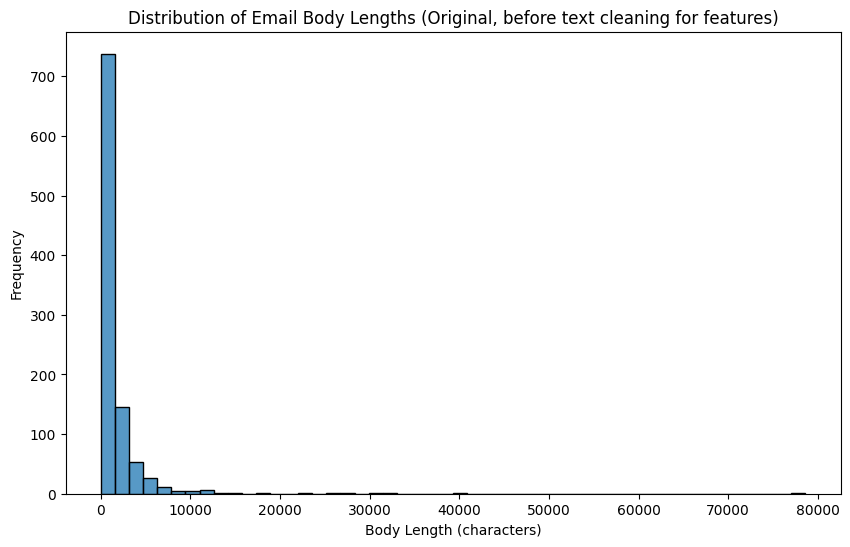

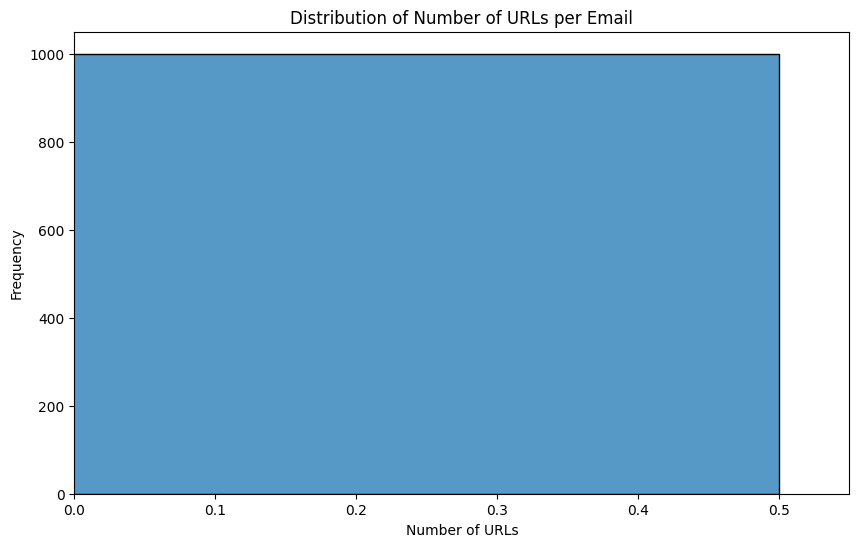


--- Sample Cleaned Email Bodies (first 200 chars) ---

File: linder-e/all_documents/226.
Subject: start date 4601 hourahead hour 9 codesite
Body Snippet: start date 4601 hourahead hour 9 no ancillary schedules awarded. no variances detected. log messages parsing file  oportlandwestdeskcalifornia schedulingiso final schedules2001040609.txt  energy impor
URLs: []

File: cash-m/deleted_items/446.
Subject: re fw information request for due diligence
Body Snippet: thanks  keep it coming! katie note the information contained in this email message is intended only for use of the individual or entity named above. if the reader of this message is not the intended r
URLs: []

File: dasovich-j/notes_inbox/11560.
Subject: fw 5 state energy advisors fired over conflicts ethics the consultants were involved in buying electricity for california from a generator whose stock they owned, setting up a clash of official duties, personal interests.
Body Snippet: names of the 5 people fired disclosed below

In [ ]:
if not df_processed_enron_sample.empty:
    print("--- Basic Stats of Processed Data ---")

    # Stats for object columns
    print(df_processed_enron_sample.describe(include='object'))

    # Stats for numerical
    print(df_processed_enron_sample[['body_length', 'num_urls']].describe())

    # Distribution of email body lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(df_processed_enron_sample['body_length'], bins=50, kde=False)
    plt.title('Distribution of Email Body Lengths (Original, before text cleaning for features)')
    plt.xlabel('Body Length (characters)')
    plt.ylabel('Frequency')
    plt.show()

    # Distribution of number of URLs found
    plt.figure(figsize=(10, 6))
    sns.histplot(df_processed_enron_sample['num_urls'], bins=max(1, df_processed_enron_sample['num_urls'].max()), kde=False) # Ensure bins are at least 1
    plt.title('Distribution of Number of URLs per Email')
    plt.xlabel('Number of URLs')
    plt.ylabel('Frequency')
    plt.xlim(left=0) # Start x-axis at 0
    plt.show()

    print("\n--- Sample Cleaned Email Bodies (first 200 chars) ---")
    for idx, row in df_processed_enron_sample.sample(min(3, len(df_processed_enron_sample))).iterrows():
        print(f"\nFile: {row['original_file']}")
        print(f"Subject: {row['subject_cleaned']}")
        print(f"Body Snippet: {row['body_cleaned'][:200]}")
        print(f"URLs: {row['urls_in_email'][:3]}") # Show first 3 URLs
else:
    print("Processed sample is empty. Skipping further EDA.")

## 8 Save preprocessed data

Save the cleaned and labeled Enron (ham) data to the current Google Colab runtime environment.

In [ ]:
if not df_processed_enron_sample.empty:
    OUTPUT_FILENAME = f'enron_ham_processed_sample_{len(df_processed_enron_sample)}.csv'
    OUTPUT_PATH_COLAB = OUTPUT_FILENAME

    try:
        df_processed_enron_sample.to_csv(OUTPUT_PATH_COLAB, index=False)
        print(f"Processed Enron (ham) sample data saved to Colab runtime at: /content/{OUTPUT_PATH_COLAB}")

    except Exception as e: print(f"Error saving processed data to Colab runtime: {e}")

else:
    print("Processed DataFrame is empty. Nothing to save.")

Processed Enron (ham) sample data saved to Colab runtime at: /content/enron_ham_processed_sample_1000.csv
IMPORTANT: This file is temporary. Download it or save to Google Drive to keep it.
